# EDS 220 Final Project

## Instructions

1. Data access and initial cleaning: BII data: This dataset is part of the MPC STAC catalog. You will need to access the ‘io-biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can use the following coordinates for a bounding box: 
[-112.826843, 32.974108, -111.184387, 33.863574]
Phoenix subdivision: You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

2. Create a map showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. (You can also check out the contextily package.)

3. Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.
HINTS (useful or not depending on your workflow): 
Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. 
To calculate the percentage area: (pixels in class)/(total pixels) * 100. 

4. Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.


# 1: Data Access

- You will need to access the ‘io-biodiversity’ collection
- Look for the 2017 and 2020 rasters covering Phoenix subdivision
- Use this bounding box:[-112.826843, 32.974108, -111.184387, 33.863574]
- Phoenix subdivision: You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

**Plan:**

A. Access the catalog and do a spatial search using the bounding box

B. Select and explore 2020 BII data

C. Select and explore 2017 BII data

D. Phoenix polygon: read in and explore

In [46]:
## Load libraries

import numpy as np
import geopandas as gpd
import rioxarray as rioxr
from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

import os # accessible file paths

# plotting
import matplotlib.pyplot as plt # for plotting
import matplotlib.patches as mpatches # for pretty legends

# ----- other libraries for nice ouputs
from IPython.display import Image
import contextily as ctx # for adding basemaps

## 1A: Access the catalog and do a spatial search using the bounding box
Access the catalog and do a spatial search using the bounding box

Create a search for data in the io-biodiversity dataset (id = ‘io-biodiversity’) from 2017 and 2020 that intersects the box bounds:  [-112.826843, 32.974108, -111.184387, 33.863574]

In [66]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
) # The modifier parameter is needed to access the data in the MPC catalog.

# select and view the collection
biodiv_collection = catalog.get_child('io-biodiversity')
biodiv_collection # explore the io-diversity collection

id: io-biodiversity
title: Biodiversity Intactness
"description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity metrics and contemporary, global, geospatial layers of human pressures, with the intention of providing a high resolution monitoring product into the future. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe. These methods, as well as comparisons to other leading datasets and guidance on interpreting results, are further explained in a methods [white paper](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf) entitled “Global 100m Projections of Biodiversity Intactness for the years 2017-2020.” All years are available under a Creative Commons BY-4.0 license."
"providers: Impact Observatory (processor, producer, licensor) Vizzuality (processor) Microsoft (host)"
type: Collection
"item_assets: {'data': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'Biodiversity Intactness', 'description': 'Terrestrial biodiversity intactness at 100m resolution', 'raster:bands': [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]}}"
msft:region: westeurope
msft:container: impact
msft:storage_account: pcdata01euw
msft:short_description: Global terrestrial biodiversity intactness at 100m resolution for years 2017-2020
https://stac-extensions.github.io/item-assets/v1.0.0/schema.json


In [67]:
# Search Spatial range of interest
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# catalog search
search = catalog.search(
    collections=[biodiv_collection], # list with collection id
    bbox=bbox) # include , datetime=time_range to add in the time range
search

# pull the items from the search
items = search.item_collection()

# check it worked, what is the length of our search?
len(items)
items # view them

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


## 1B: Select and explore 2020 BII data

In [68]:
### --- 2020 BII Data exploration
# select 2020 item
item2020 = items[0] # the first one is the 2020 file, indexing starts at 0

# check it worked: print item id and properties
print('id:' , item2020.id)

#print specific properties of interest
print('2020 item start: ', item2020.properties['start_datetime'])
print('2020 item end: ', item2020.properties['start_datetime'])
print('2020 item crs - espg: ', item2020.properties['proj:epsg'])

# Let's explore the item's assets
print('type: ', type(item2020.assets))
print('2020 item assets: ', item2020.assets)

# Asset exploration: 
print('2020 item asset key: ')
for key, asset in item2020.assets.items(): 
    print(key, '-', asset.title)

id: bii_2020_34.74464974521749_-115.38597824385106_cog
2020 item start:  2020-01-01T00:00:00Z
2020 item end:  2020-01-01T00:00:00Z
2020 item crs - espg:  4326
type:  <class 'dict'>
2020 item assets:  {'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-04T05%3A45%3A59Z&se=2023-12-12T05%3A46%3A00Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-05T05%3A45%3A58Z&ske=2023-12-12T05%3A45%3A58Z&sks=b&skv=2021-06-08&sig=UBQ32X/9RrHpAboyM4A2jCGbkupoXqpLgSC1PDNd1Ak%3D>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>, 'rendered_preview': <Asset href=https://planetarycomputer.micros

In [10]:
# pull the data asset and explore
item2020.assets['data']

href: https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-04T05%3A45%3A59Z&se=2023-12-12T05%3A46%3A00Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-05T05%3A45%3A58Z&ske=2023-12-12T05%3A45%3A58Z&sks=b&skv=2021-06-08&sig=UBQ32X/9RrHpAboyM4A2jCGbkupoXqpLgSC1PDNd1Ak%3D
type: image/tiff; application=geotiff; profile=cloud-optimized
title: Biodiversity Intactness
description: Terrestrial biodiversity intactness at 100m resolution
roles: ['data']
owner: bii_2020_34.74464974521749_-115.38597824385106_cog
version: v1
"raster:bands: [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]"


In [11]:
# Open the 2020 data using the href from the corresponding asset and rioxr.open_rasterio().
# Store it as a variable named data2020
data2020 = rioxr.open_rasterio(item2020.assets['data'].href)
data2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

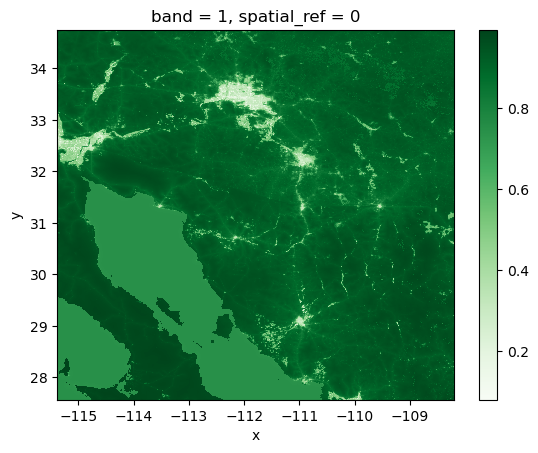

In [12]:
# exploratory plot
data2020.plot(cmap='Greens') #I saw the greens on the mpc example and liked it, more green is more intact

Consider the scale... what is the scale of biodiversity intactness? Need to look this up!
Also, the asset info does not include a scale like the ndvi did, so it looks like we do not have to rescale!

Can't find a clear scale, maybe it's a 0-1? Planetary computer's example shows that (https://planetarycomputer.microsoft.com/dataset/io-biodiversity#Example-Notebook), but papers are reporting changes in percent change. 

### Note: when to use robust=True? It doesn't look like anything is skewing the scale to make it out of whack, but the MPC example is showing it as robust = true

As a scientist, if I get to make whatever call I want to justify, I'll go with robust = True, since we do not want the biggest outliers to skew our data, and it is changing the map. 

With robust=True:


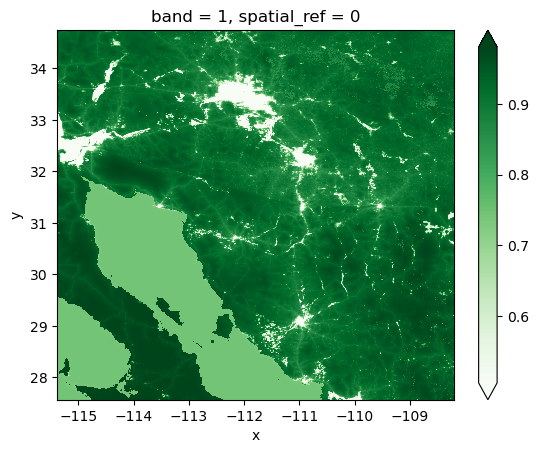

In [13]:
print('With robust=True:')
data2020.plot(cmap='Greens', robust=True) #let's check it out

## 1C: Select and explore 2017 BII data

In [14]:
# 2017 item
item2017 = items[3] # the fourth one is the 2017 file, indexing starts at 0

# check it worked: print item id and relevant properties
print('id:' , item2017.id)

#print specific properties of interest
print('2017 item start: ', item2017.properties['start_datetime'])
print('2017 item end: ', item2017.properties['start_datetime'])
print('2017 item crs - espg: ', item2017.properties['proj:epsg'])

# Let's explore the item's assets
print('type: ', type(item2017.assets))
print(item2017.assets)

# Asset exploration:
for key, asset in item2017.assets.items(): 
    print(key, '-', asset.title)
    
# pull the data asset and explore
item2017.assets['data']

id: bii_2017_34.74464974521749_-115.38597824385106_cog
2017 item start:  2017-01-01T00:00:00Z
2017 item end:  2017-01-01T00:00:00Z
2017 item crs - espg:  4326
type:  <class 'dict'>
{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-04T05%3A45%3A59Z&se=2023-12-12T05%3A46%3A00Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-05T05%3A45%3A58Z&ske=2023-12-12T05%3A45%3A58Z&sks=b&skv=2021-06-08&sig=UBQ32X/9RrHpAboyM4A2jCGbkupoXqpLgSC1PDNd1Ak%3D>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>, 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1

href: https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-04T05%3A45%3A59Z&se=2023-12-12T05%3A46%3A00Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-05T05%3A45%3A58Z&ske=2023-12-12T05%3A45%3A58Z&sks=b&skv=2021-06-08&sig=UBQ32X/9RrHpAboyM4A2jCGbkupoXqpLgSC1PDNd1Ak%3D
type: image/tiff; application=geotiff; profile=cloud-optimized
title: Biodiversity Intactness
description: Terrestrial biodiversity intactness at 100m resolution
roles: ['data']
owner: bii_2017_34.74464974521749_-115.38597824385106_cog
version: v1
"raster:bands: [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]"


In [15]:
# Open the 2017 data using the href from the corresponding asset and rioxr.open_rasterio().
# Store it as a variable named data2017
data2017 = rioxr.open_rasterio(item2017.assets['data'].href)
data2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

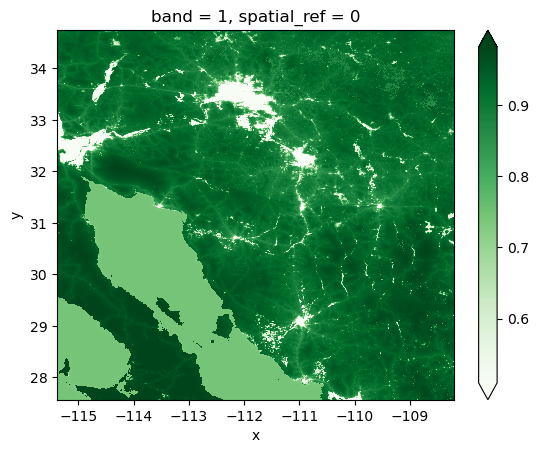

In [16]:
# exploratory plot
data2017.plot(cmap='Greens', robust=True) #I saw the greens on the mpc example and liked it, more green is more intact

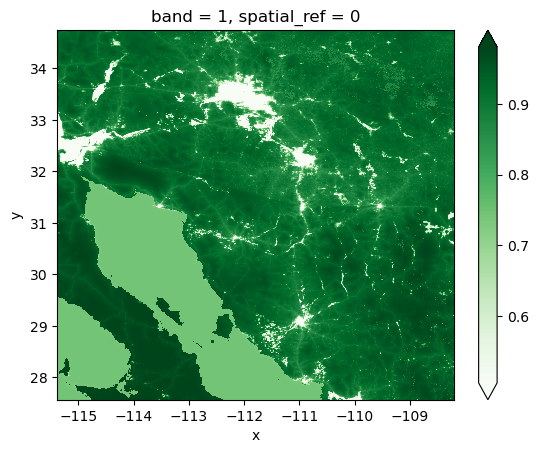

In [17]:
data2020.plot(cmap='Greens', robust=True) #let's check it out

## 1D: Phoenix polygon: read in and explore
You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

In [80]:
# read in data
az_fp = os.path.join(os.getcwd(),'data','tl_2022_04_cousub.shp')
az = gpd.read_file(az_fp) # use gpd to read the file because it's a shapefile
az.columns = az.columns.str.lower() #esnure column names are lowercase
az.head(2) # check it imported by viewing top 2 rows

,statefp,countyfp,cousubfp,cousubns,geoid,name,namelsad,lsad,classfp,mtfcc,cnectafp,nectafp,nctadvfp,funcstat,aland,awater,intptlat,intptlon,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


['Flagstaff' 'Kaibab Plateau' 'Hualapai' 'Nogales' 'Patagonia' 'Hopi'
 'Tuba City' 'Clifton' 'Duncan' 'Chandler' 'Phoenix'
 'Tonto National Forest' 'Gila Bend' 'Wickenburg' 'Deer Valley' 'Buckeye'
 'St. Johns' 'Salt River' 'Tucson' 'Arivaca' 'Indian Wells'
 'Winslow-Holbrook' 'Snowflake' 'Kayenta' 'Lake Havasu City' 'Fort Apache'
 'Bisbee' 'Bowie' 'Willcox' 'North Mohave' 'Kingman' 'Bullhead City'
 'Congress' 'Mingus Mountain' 'Florence' 'North Pinal' 'San Manuel' 'Eloy'
 'Chinle' 'Sweetwater' 'Fort Defiance' 'Dennehotso' 'Puerco' 'Ash Fork'
 'Cordes Lakes-Mayer' 'Camp Verde-Sedona' 'Prescott' 'Piñon' 'Payson'
 'Winkelman' 'Globe-Miami' 'Tonto Basin' 'Gila River' 'Casa Grande'
 'Maricopa-Stanfield' "Tohono O'odham Nation" 'Coolidge' 'Ajo' 'Marana'
 'Somerton' 'Bonita-Klondyke' 'Eagar-Springerville' 'San Carlos'
 'Havasupai' 'Williams' 'Pima' 'Safford' 'Wellton' 'Yuma' 'Parker'
 'Benson' 'Douglas' 'Sierra Vista' 'Elfrida']
unique names in subset (expecting only Phonix):  ['Phoenix']
pho

<Axes: >

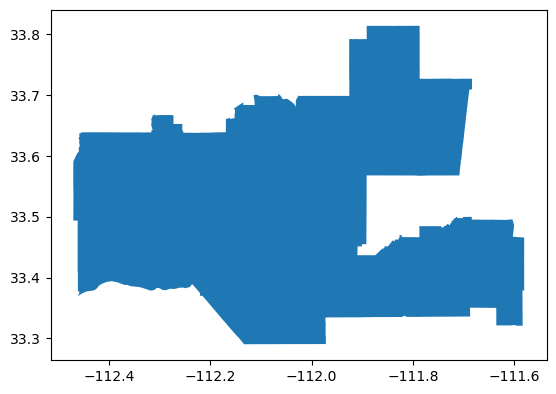

In [81]:
# get list of unique values of counties and look for Phoenix
print(az.name.unique())

# subset only Phoenix
phoenix = az[(az.name=='Phoenix')]
# ensure it worked
print('unique names in subset (expecting only Phonix): ', phoenix.name.unique())

# explore the phoenix shapefile
# print crs
print('phoenix shapefile crs: ', phoenix.crs)
# exploratory plot it
phoenix.plot()

unique names in subset (expecting only Phonix):  ['Phoenix']
phoenix shapefile crs:  EPSG:4269


<Axes: >

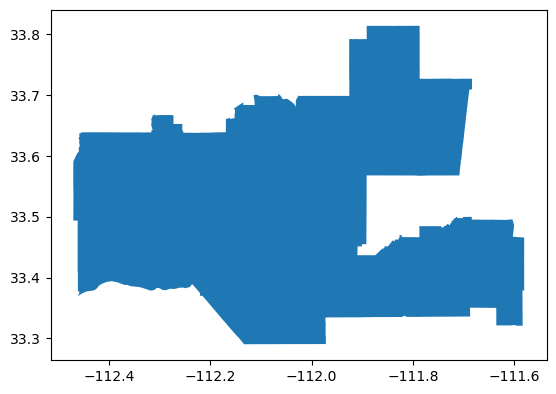

# 2: Phoenix map with geographical context

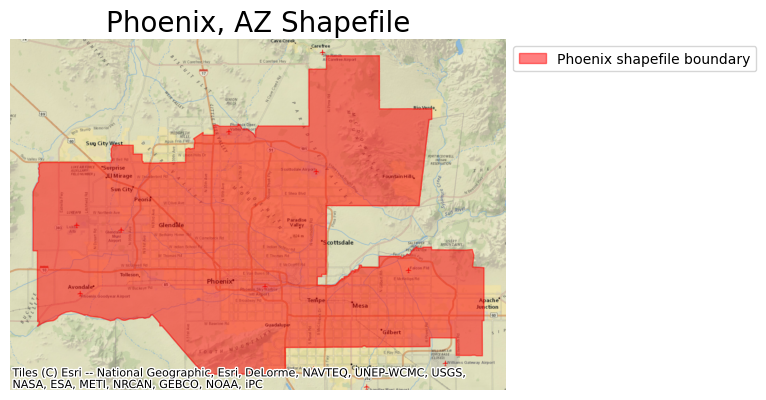

In [79]:
fig, ax=plt.subplots()
ax.axis('off') # remove the pesky box

#----------------------------------
# add the Phoenix Shapefile
(phoenix.to_crs(epsg=3857) #change to epsg 3857, best for contextily
 .plot(ax=ax, figsize=(5,5), alpha=0.5, edgecolor='red', color='red') 
)
# make legend pretty
bbox_patch = mpatches.Patch(color='red', alpha=0.5, label = 'Phoenix shapefile boundary')

#----------------------------------
# add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

#----------------------------------
# create a legend
ax.legend(handles = [bbox_patch], loc='upper left', bbox_to_anchor=(1,1))

# add a title
ax.set_title('Phoenix, AZ Shapefile', fontsize=20)

plt.show()

# 3 Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 & 2020

HINTS (useful or not depending on your workflow): 
Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. 
To calculate the percentage area: (pixels in class)/(total pixels) * 100. 

**Plan**
A: clip BII data to Phoenix subdivision (first squeeze, reproject, etc) for 2017 and 2020

B: calculations

In [ ]:
## 3A: 